In [1]:
import pandas as pd
import jax
import jax.numpy as jnp
import numpy as np
import optax
from flax.training import train_state
from functools import partial
# from relative_fitness_mechanisms.selective_pressure_prediction import (create_lagged_features, 
#                                                                        process_inputs_all, 
#                                                                        withhold_test_locations_and_split, 
#                                                                        SelectivePressureData
#                                                                        create_training_batches,
#                                                                       train_step, 
#                                                                       loss_fn)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import string

In [2]:
## Prepping data

import sys
sys.path.append( '../relative_fitness_mechanisms/')
import plot_utils
from selective_pressure_prediction import (create_lagged_features, 
                                           process_inputs_all, 
                                            withhold_test_locations_and_split, 
                                            SelectivePressureData,
                                            SelectivePressureTSData,
                                            create_training_batches,
                                            train_step)

from ml_utils import TrainerModule

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases_full.tsv", sep="\t")
#selective_pressure_df = pd.read_csv("../data/selective_pressure_growth_cases.tsv", sep="\t")

selective_pressure_df["date"] = pd.to_datetime(selective_pressure_df["date"])

In [4]:
selective_pressure_df = selective_pressure_df.dropna()

In [5]:
#excluded = ["Minnesota", "Colorado", "Tennesee", "North Dakota", "Missouri", "Indiana", "Florida", "Connecticut"]
#selective_pressure_df = selective_pressure_df[~selective_pressure_df.location.isin(excluded)]
#included = ["England", "California",   "Michigan", "Nevada", "New York", "Texas", "Washington"]
#selective_pressure_df = selective_pressure_df[selective_pressure_df.location.isin(included)]


In [6]:
input_dfs = {}
TARGET = "empirical_growth_rate"
keep_features = ["date", "location", "selective_pressure"]
keep_targets = [TARGET]

# Create lagged features by group
for loc, group in selective_pressure_df.groupby("location"):
    input_dfs[loc] = create_lagged_features(
        group[keep_features + keep_targets], 
        ["selective_pressure"], 
        28)

In [7]:
inputs_dfs = {loc: input_df.dropna() for loc, input_df in input_dfs.items()}
dates_vec, locations_vec, X, y = process_inputs_all(input_dfs, target=TARGET)

In [8]:
WITHHELD_LOCATIONS = ["England"]
X_train, y_train, X_test, y_test = withhold_test_locations_and_split(X, y, locations_vec, WITHHELD_LOCATIONS)

In [9]:
from ml_utils import create_data_loaders

train_set = SelectivePressureTSData(
    X_train.values,
    y_train.values,
    locations_vec[X_train.index],
    dates_vec[X_train.index],
    sequence_length=32
)
val_set = SelectivePressureTSData(
    X_test.values,
    y_test.values,
    locations_vec[X_test.index],
    dates_vec[X_train.index],
    sequence_length=1
)

train_loader, val_loader = create_data_loaders(train_set, val_set,
                                                            train=[True, False],
                                                            batch_size=1,
                                                            num_workers=1)

# THIS BREAKS THINGS

In [20]:
from ml_utils import create_data_loaders

    
train_set = SelectivePressureData(X_train.values, y_train.values)
val_set = SelectivePressureData(X_test.values, y_test.values)

train_loader, val_loader = create_data_loaders(train_set, val_set,
                                                            train=[True, False],
                                                            batch_size=128,
                                                           num_workers=1)

In [21]:
# Defining model
from flax import linen as nn

class PositionalEncoding(nn.Module):
    max_len: int
    d_model: int

    @nn.compact
    def __call__(self, x):
        pe = self.positional_encoding(self.max_len, self.d_model)
        pe = pe[:x.shape[1], :]  # Adjust the length to match the input sequence length
        pe = jnp.expand_dims(pe, axis=0)  # Add batch dimension
        x = x + pe  # Broadcasting positional encoding to the batch size
        return x
    
    def positional_encoding(self, max_len, d_model):
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        return pe
    
class FeedForward(nn.Module):
    d_model: int
    d_ff: int
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_model)(x)
        return x
    
class BlockLayer(nn.Module):
    d_model: int
    num_heads: int
    d_ff: int

    @nn.compact
    def __call__(self, x):
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads, qkv_features=self.d_model, use_bias=True
        )(x)
        x = nn.LayerNorm()(x + attn_output)

        ff_output = FeedForward(d_model=self.d_model, d_ff=self.d_ff)(x)
        x =  nn.LayerNorm()(x + ff_output)
        return x
    
class SimpleTransformer(nn.Module):
    num_heads: int
    d_model: int  # Size of the attention representations
    d_ff: int  # Size of feedforward
    output_dim: int  # Dimensionality of the regression output

    @nn.compact
    def __call__(self, x, **kwargs):
        x = nn.Dense(self.d_model)(x)
        x = nn.relu(x)
        
        x = jnp.expand_dims(x, axis=-1)
        x = PositionalEncoding(max_len=x.shape[1], d_model=self.d_model)(x)
        
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)
        x = BlockLayer(d_model=self.d_model, num_heads=self.num_heads, d_ff=self.d_ff)(x)

        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)        
        x = nn.Dense(self.output_dim)(x)
        x = jnp.squeeze(x, axis=-1)
        x = jnp.mean(x, axis=-1)
        return x
    
# Define loss function
#combined_loss_fn = partial(loss_fn, alpha=1e-4)

In [22]:
# Defining model
from flax import linen as nn

class PositionalEncoding(nn.Module):
    max_len: int
    d_model: int

    @nn.compact
    def __call__(self, x):
        pe = self.positional_encoding(self.max_len, self.d_model)
        pe = pe[:x.shape[1], :]  # Adjust the length to match the input sequence length
        pe = jnp.expand_dims(pe, axis=0)  # Add batch dimension
        x = x + pe  # Broadcasting positional encoding to the batch size
        return x
    
    def positional_encoding(self, max_len, d_model):
        position = np.arange(max_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
        pe = np.zeros((max_len, d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        return pe
    
class FeedForward(nn.Module):
    d_model: int
    d_ff: int
        
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_model)(x)
        return x
    
class BlockLayer(nn.Module):
    d_model: int
    num_heads: int
    d_ff: int
    dropout_rate: float

    @nn.compact
    def __call__(self, x, deterministic):
        attn_output = nn.MultiHeadDotProductAttention(
            num_heads=self.num_heads, qkv_features=self.d_model, use_bias=True
        )(x)
        x = nn.LayerNorm()(x + attn_output)
        #x = nn.Dropout(rate=self.dropout_rate, deterministic=deterministic)(x)

        ff_output = FeedForward(d_model=self.d_model, d_ff=self.d_ff)(x)
        x =  nn.LayerNorm()(x + ff_output)
        #x = nn.Dropout(rate=self.dropout_rate, deterministic=deterministic)(x)
        return x
    
class SimpleTransformer(nn.Module):
    num_heads: int
    d_model: int  # Size of the attention representations
    d_ff: int  # Size of feedforward
    output_dim: int  # Dimensionality of the regression output
    dropout_rate: float # Probability of dropout

    @nn.compact
    def __call__(self, x, deterministic, **kwargs):
        x = nn.Dense(self.d_model)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_model)(x)
        x = nn.relu(x)

        x = jnp.expand_dims(x, axis=-1)
        x = PositionalEncoding(max_len=x.shape[1], d_model=self.d_model)(x)
        
        for _ in range(3):
            x = BlockLayer(
                d_model=self.d_model,
                num_heads=self.num_heads,
                d_ff=self.d_ff,
                dropout_rate=self.dropout_rate
            )(x, deterministic)

        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)
        x = nn.Dense(self.d_ff)(x)
        x = nn.relu(x)        
        x = nn.Dense(self.output_dim)(x)
        x = jnp.squeeze(x, axis=-1)
        x = jnp.mean(x, axis=-1)
        return x
    
# Define loss function
alpha = 1e-4

In [23]:

class TransformerTrainer(TrainerModule):

    def __init__(self,
                 num_heads, 
                 d_model, 
                 d_ff, 
                 output_dim,
                 **kwargs):
        super().__init__(
            model_class=SimpleTransformer, 
            model_hparams={
                'num_heads': num_heads,
                'd_model': d_model,
                'd_ff': d_ff,
                'output_dim': output_dim
            }, **kwargs)

    def create_functions(self):
        def train_step(state, batch):
            """
            Perform a single training step.
            
            Args:
              state: The current training state.
              batch: A batch of training data.
              
            Returns:
              Updated training state and training metrics.
            """
            x, y = batch
            grad_fn = jax.value_and_grad(lambda p: combined_loss_fn({'params': p}, state, x, y))
            loss, grads = grad_fn(state.params)
            state = state.apply_gradients(grads=grads)

            metrics = {
                'loss': loss,
            }
            return state, metrics

        def eval_step(state, batch):
            """
            Perform a single evaluation step.
            
            Args:
              state: The current training state.
              batch: A batch of evaluation data.
              
            Returns:
              Evaluation metrics.
            """
            x, y = batch
            loss = combined_loss_fn({'params': state.params}, state, x, y)
            
            metrics = {
                'loss': loss,
            }

            return metrics

        return train_step, eval_step

In [31]:
from jax import random, jit

def smoothness_loss(predictions, x, boundary_handling=True):
    # Shifted predictions for t+1 and t-1
    predictions_shifted_right = jnp.roll(predictions, -1, axis=0)
    predictions_shifted_left = jnp.roll(predictions, 1, axis=0)

    # Compute the finite differences second derivative
    second_derivative = (
        predictions_shifted_left - 2 * predictions + predictions_shifted_right
    )

    if boundary_handling:
        second_derivative = jnp.where(
            (jnp.arange(predictions.shape[0]) == 0) | 
            (jnp.arange(predictions.shape[0]) == predictions.shape[0] - 1), 
            0, 
            second_derivative
        )

    # Penalize large derivatives (i.e., encourage smoothness)
    return jnp.mean(jnp.square(second_derivative))


class TransformerTrainer(TrainerModule):

    def __init__(self,
                 num_heads, 
                 d_model, 
                 d_ff, 
                 output_dim,
                 dropout_rate,
                 **kwargs):
        super().__init__(
            model_class=SimpleTransformer, 
            model_hparams={
                'num_heads': num_heads,
                'd_model': d_model,
                'd_ff': d_ff,
                'dropout_rate': dropout_rate,
                'output_dim': output_dim
            }, **kwargs)
        
    def run_model_init(self, exmp_input, init_rng):
        x = exmp_input[0]
        #x = x.squeeze(0)
        init_rng, dropout_rng = random.split(init_rng)
        return self.model.init({'params': init_rng, 'dropout': dropout_rng}, x=x, deterministic=True)
    
    def print_tabulate(self, exmp_input):
        x = exmp_input[0]
        #x = x.squeeze(0)
        print(self.model.tabulate(rngs={'params': random.PRNGKey(0), 'dropout': random.PRNGKey(1)}, x=x, deterministic=False))
    
    def create_functions(self):
        
        def loss_fn(params, state, x, y, rng, train):
            rng, dropout_rng = random.split(rng)
            predictions = state.apply_fn(params, x, deterministic = not train, rngs={'dropout': dropout_rng},)
            mae_loss = jnp.mean(jnp.abs(predictions - y))
            #mse_loss = jnp.mean(jnp.square(predictions - y))
            loss_smooth = smoothness_loss(predictions, x)
            return mae_loss + alpha * loss_smooth, (mae_loss, loss_smooth, rng)

        @jit
        def train_step(state, batch):
            """
            Perform a single training step.
            
            Args:
              state: The current training state.
              batch: A batch of training data.
              
            Returns:
              Updated training state and training metrics.
            """
            x, y = batch
            #x = x.squeeze(0)
            #y = y.squeeze(0)
            grad_fn = jax.value_and_grad(lambda p: loss_fn({'params': p}, state, x, y, state.rng, train=True), has_aux=True)
            ret, grads = grad_fn(state.params)
            loss, (mae_loss, loss_smooth, rng) = ret
            state = state.apply_gradients(grads=grads, rng=rng)

            metrics = {
                'loss': loss,
                'mae': mae_loss,
                'smooth': loss_smooth
            }
            return state, metrics

        @jit
        def eval_step(state, batch):
            """
            Perform a single evaluation step.
            
            Args:
              state: The current training state.
              batch: A batch of evaluation data.
              
            Returns:
              Evaluation metrics.
            """
            x, y = batch
            #x = x.squeeze(0)
            #y = y.squeeze(0)
            loss, _ = loss_fn({'params': state.params}, state, x, y, state.rng, train=False)
            metrics = {
                'loss': loss,
            }

            return metrics

        return train_step, eval_step

In [32]:
import os

trainer = TransformerTrainer(
    num_heads=16, 
    d_model= 64, 
    d_ff=64, 
    output_dim=1,
    dropout_rate=0.3,
    optimizer="adamw",
    optimizer_hparams={'lr': 4e-4}, 
    exmp_input=next(iter(train_loader))[0:1],
    logger_params={'base_log_dir': os.path.abspath("./saved_models/")})


                           SimpleTransformer Summary                            
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ path          ┃ module        ┃ inputs        ┃ outputs      ┃ params        ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│               │ SimpleTransf… │ deterministi… │ float32[128] │               │
│               │               │ False         │              │               │
│               │               │ x:            │              │               │
│               │               │ float32[128,… │              │               │
├───────────────┼───────────────┼───────────────┼──────────────┼───────────────┤
│ Dense_0       │ Dense         │ float32[128,… │ float32[128… │ bias:         │
│               │               │               │              │ float32[64]   │
│               │               │               │              │ kernel:       │
│               │          

In [33]:
metrics = trainer.train_model(train_loader,
                              val_loader,
                              test_loader=None,
                              num_epochs=100);
metrics

Training:  50%|███████████████████████████████████████████▉                                           | 56/111 [00:11<00:07,  7.34it/s]


Epochs:   1%|▉                                                                                         | 1/100 [00:23<39:24, 23.89s/it]


Training:  51%|████████████████████████████████████████████▋                                          | 57/111 [00:07<00:07,  7.27it/s]


Training:   0%|                                                                                                | 0/111 [00:00<?, ?it/s]


Training:  52%|█████████████████████████████████████████████▍                                         | 58/111 [00:08<00:07,  7.22it/s]


Training:   1%|▊                                                                                       | 1/111 [00:00<00:15,  7.01it/s]


Training:  53%|██████████████████████████████████████████████▏                                        | 59/111 [00:08<00:07,  7.20it/s]


Training:   2%|█▌                                                                                      | 2/111 [00:00<00:15,  7.02it/s]


Training:  54%|███████████████████████████████████████████████                                        | 60/111 [00:08<00:07,  7.05it/s]


Training:   3%|██▍                                                                                     | 3/111 [00:00<00:15,  7.16it/s]


Training:  55%|███████████████████████████████████████████████▊                                       | 61/111 [00:08<00:07,  7.07it/s]


Training:   4%|███▏                                                                                    | 4/111 [00:00<00:15,  7.08it/s]


Training:  56%|████████████████████████████████████████████████▌                                      | 62/111 [00:08<00:06,  7.09it/s]


Training:   5%|███▉                                                                                    | 5/111 [00:00<00:14,  7.09it/s]


Training:  57%|█████████████████████████████████████████████████▍                                     | 63/111 [00:09<00:06,  7.02it/s]


Training:   5%|████▊                                                                                   | 6/111 [00:00<00:14,  7.09it/s]


Training:  58%|██████████████████████████████████████████████████▏                                    | 64/111 [00:08<00:06,  7.17it/s]


Training:   6%|█████▌                                                                                  | 7/111 [00:00<00:14,  7.14it/s]


Training:  59%|██████████████████████████████████████████████████▉                                    | 65/111 [00:09<00:06,  7.20it/s]


Training:   7%|██████▎                                                                                 | 8/111 [00:01<00:14,  7.11it/s]


Training:  59%|███████████████████████████████████████████████████▋                                   | 66/111 [00:09<00:06,  6.99it/s]


Training:   8%|███████▏                                                                                | 9/111 [00:01<00:14,  7.07it/s]


Training:  60%|████████████████████████████████████████████████████▌                                  | 67/111 [00:09<00:06,  7.08it/s]


Training:   9%|███████▊                                                                               | 10/111 [00:01<00:14,  6.96it/s]


Training:  61%|█████████████████████████████████████████████████████▎                                 | 68/111 [00:09<00:06,  7.08it/s]


Training:  10%|████████▌                                                                              | 11/111 [00:01<00:13,  7.18it/s]


Training:  62%|██████████████████████████████████████████████████████                                 | 69/111 [00:09<00:06,  6.91it/s]


Training:  11%|█████████▍                                                                             | 12/111 [00:01<00:13,  7.19it/s]


Training:  63%|██████████████████████████████████████████████████████▊                                | 70/111 [00:10<00:05,  7.16it/s]


Training:  12%|██████████▏                                                                            | 13/111 [00:01<00:13,  7.14it/s]


Training:  64%|███████████████████████████████████████████████████████▋                               | 71/111 [00:10<00:05,  7.03it/s]


Training:  13%|██████████▉                                                                            | 14/111 [00:01<00:13,  7.09it/s]


Training:  65%|████████████████████████████████████████████████████████▍                              | 72/111 [00:10<00:05,  7.13it/s]


Training:  14%|███████████▊                                                                           | 15/111 [00:02<00:13,  7.17it/s]


Training:  66%|█████████████████████████████████████████████████████████▏                             | 73/111 [00:10<00:05,  7.15it/s]


Training:  14%|████████████▌                                                                          | 16/111 [00:02<00:13,  6.99it/s]


Training:  67%|██████████████████████████████████████████████████████████                             | 74/111 [00:10<00:05,  7.12it/s]


Training:  15%|█████████████▎                                                                         | 17/111 [00:02<00:13,  7.18it/s]


Training:  68%|██████████████████████████████████████████████████████████▊                            | 75/111 [00:10<00:05,  6.95it/s]


Training:  16%|██████████████                                                                         | 18/111 [00:02<00:13,  6.79it/s]


Training:  68%|███████████████████████████████████████████████████████████▌                           | 76/111 [00:12<00:06,  5.53it/s]


Training:  17%|██████████████▉                                                                        | 19/111 [00:02<00:13,  6.59it/s]


Training:  69%|████████████████████████████████████████████████████████████▎                          | 77/111 [00:13<00:04,  6.99it/s]


Training:  18%|███████████████▋                                                                       | 20/111 [00:03<00:14,  6.28it/s]


Training:  70%|█████████████████████████████████████████████████████████████▏                         | 78/111 [00:11<00:04,  7.06it/s]


Training:  19%|████████████████▍                                                                      | 21/111 [00:03<00:12,  7.13it/s]


Training:  71%|█████████████████████████████████████████████████████████████▉                         | 79/111 [00:11<00:04,  7.18it/s]


Training:  20%|█████████████████▏                                                                     | 22/111 [00:03<00:12,  7.21it/s]


Training:  72%|██████████████████████████████████████████████████████████████▋                        | 80/111 [00:11<00:04,  7.10it/s]


Training:  21%|██████████████████                                                                     | 23/111 [00:03<00:12,  6.79it/s]


Training:  73%|███████████████████████████████████████████████████████████████▍                       | 81/111 [00:11<00:04,  7.14it/s]


Training:  22%|██████████████████▊                                                                    | 24/111 [00:03<00:13,  6.50it/s]


Training:  74%|████████████████████████████████████████████████████████████████▎                      | 82/111 [00:12<00:04,  7.04it/s]


Training:  23%|███████████████████▌                                                                   | 25/111 [00:03<00:12,  6.68it/s]


Training:  75%|█████████████████████████████████████████████████████████████████                      | 83/111 [00:16<00:05,  4.71it/s]


Training:  23%|████████████████████▍                                                                  | 26/111 [00:04<00:12,  6.69it/s]


Training:  76%|█████████████████████████████████████████████████████████████████▊                     | 84/111 [00:12<00:04,  6.71it/s]


Training:  24%|█████████████████████▏                                                                 | 27/111 [00:03<00:12,  6.87it/s]


Training:  77%|██████████████████████████████████████████████████████████████████▌                    | 85/111 [00:12<00:03,  7.06it/s]


Training:  25%|█████████████████████▉                                                                 | 28/111 [00:04<00:11,  6.92it/s]


Training:  77%|███████████████████████████████████████████████████████████████████▍                   | 86/111 [00:12<00:03,  7.01it/s]


Training:  26%|██████████████████████▋                                                                | 29/111 [00:04<00:11,  6.94it/s]


Training:  78%|████████████████████████████████████████████████████████████████████▏                  | 87/111 [00:12<00:03,  7.05it/s]


Training:  27%|███████████████████████▌                                                               | 30/111 [00:04<00:11,  7.00it/s]


Training:  79%|████████████████████████████████████████████████████████████████████▉                  | 88/111 [00:12<00:03,  7.02it/s]


Training:  28%|████████████████████████▎                                                              | 31/111 [00:04<00:11,  7.03it/s]


Training:  80%|█████████████████████████████████████████████████████████████████████▊                 | 89/111 [00:12<00:03,  7.10it/s]


Training:  29%|█████████████████████████                                                              | 32/111 [00:04<00:11,  6.92it/s]


Training:  81%|██████████████████████████████████████████████████████████████████████▌                | 90/111 [00:12<00:03,  6.94it/s]


Training:  30%|█████████████████████████▊                                                             | 33/111 [00:04<00:10,  7.13it/s]


Training:  82%|███████████████████████████████████████████████████████████████████████▎               | 91/111 [00:13<00:03,  5.92it/s]


Training:  31%|██████████████████████████▋                                                            | 34/111 [00:05<00:11,  6.68it/s]


Training:  83%|████████████████████████████████████████████████████████████████████████               | 92/111 [00:14<00:02,  6.56it/s]


Training:  32%|███████████████████████████▍                                                           | 35/111 [00:05<00:11,  6.86it/s]


Training:  84%|████████████████████████████████████████████████████████████████████████▉              | 93/111 [00:13<00:02,  6.88it/s]


Training:  32%|████████████████████████████▏                                                          | 36/111 [00:05<00:11,  6.79it/s]


Training:  85%|█████████████████████████████████████████████████████████████████████████▋             | 94/111 [00:13<00:02,  6.79it/s]


Training:  33%|█████████████████████████████                                                          | 37/111 [00:05<00:10,  6.91it/s]


Training:  86%|██████████████████████████████████████████████████████████████████████████▍            | 95/111 [00:14<00:02,  6.99it/s]


Training:  34%|█████████████████████████████▊                                                         | 38/111 [00:05<00:10,  7.09it/s]


Training:  86%|███████████████████████████████████████████████████████████████████████████▏           | 96/111 [00:13<00:02,  7.09it/s]


Training:  35%|██████████████████████████████▌                                                        | 39/111 [00:05<00:10,  7.14it/s]


Training:  87%|████████████████████████████████████████████████████████████████████████████           | 97/111 [00:14<00:01,  7.05it/s]


Training:  36%|███████████████████████████████▎                                                       | 40/111 [00:05<00:10,  6.72it/s]


Training:  88%|████████████████████████████████████████████████████████████████████████████▊          | 98/111 [00:14<00:01,  7.16it/s]


Training:  37%|████████████████████████████████▏                                                      | 41/111 [00:06<00:10,  6.85it/s]


Training:  89%|█████████████████████████████████████████████████████████████████████████████▌         | 99/111 [00:14<00:01,  6.81it/s]


Training:  38%|████████████████████████████████▉                                                      | 42/111 [00:06<00:09,  7.07it/s]


Training:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 100/111 [00:14<00:01,  6.95it/s]


Training:  39%|█████████████████████████████████▋                                                     | 43/111 [00:06<00:09,  6.83it/s]


Training:  91%|██████████████████████████████████████████████████████████████████████████████▎       | 101/111 [00:14<00:01,  7.08it/s]


Training:  40%|██████████████████████████████████▍                                                    | 44/111 [00:06<00:09,  7.11it/s]


Training:  92%|███████████████████████████████████████████████████████████████████████████████       | 102/111 [00:14<00:01,  6.83it/s]


Training:  41%|███████████████████████████████████▎                                                   | 45/111 [00:06<00:09,  6.99it/s]


Training:  93%|███████████████████████████████████████████████████████████████████████████████▊      | 103/111 [00:14<00:01,  6.99it/s]


Training:  41%|████████████████████████████████████                                                   | 46/111 [00:07<00:09,  6.90it/s]


Training:  94%|████████████████████████████████████████████████████████████████████████████████▌     | 104/111 [00:15<00:00,  7.15it/s]


Training:  42%|████████████████████████████████████▊                                                  | 47/111 [00:06<00:09,  6.92it/s]


Training:  95%|█████████████████████████████████████████████████████████████████████████████████▎    | 105/111 [00:14<00:00,  7.18it/s]


Training:  43%|█████████████████████████████████████▌                                                 | 48/111 [00:06<00:09,  6.99it/s]


Training:  95%|██████████████████████████████████████████████████████████████████████████████████▏   | 106/111 [00:15<00:00,  7.10it/s]


Training:  44%|██████████████████████████████████████▍                                                | 49/111 [00:06<00:08,  7.15it/s]


Training:  96%|██████████████████████████████████████████████████████████████████████████████████▉   | 107/111 [00:14<00:00,  7.16it/s]


Training:  45%|███████████████████████████████████████▏                                               | 50/111 [00:06<00:08,  7.20it/s]


Training:  97%|███████████████████████████████████████████████████████████████████████████████████▋  | 108/111 [00:15<00:00,  7.22it/s]


Training:  46%|███████████████████████████████████████▉                                               | 51/111 [00:07<00:08,  7.24it/s]


Training:  98%|████████████████████████████████████████████████████████████████████████████████████▍ | 109/111 [00:15<00:00,  7.21it/s]


Training:  47%|████████████████████████████████████████▊                                              | 52/111 [00:07<00:08,  7.10it/s]


Training:  99%|█████████████████████████████████████████████████████████████████████████████████████▏| 110/111 [00:15<00:00,  7.21it/s]


Training:  48%|█████████████████████████████████████████▌                                             | 53/111 [00:07<00:08,  7.14it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:15<00:00,  7.16it/s]


Training:  49%|██████████████████████████████████████████▎                                            | 54/111 [00:07<00:08,  7.12it/s]


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████| 111/111 [00:15<00:00,  7.08it/s]


Training:  50%|███████████████████████████████████████████▉                                           | 56/111 [00:07<00:07,  7.16it/s]


Epochs:  58%|███████████████████████████████████████████████████▌                                     | 58/100 [19:47<13:47, 19.71s/it]


Training:  51%|████████████████████████████████████████████▋                                          | 57/111 [00:08<00:07,  7.12it/s]


Training:   0%|                                                                                                | 0/111 [00:00<?, ?it/s]


Training:  52%|█████████████████████████████████████████████▍                                         | 58/111 [00:08<00:07,  6.91it/s]


Training:   1%|▊                                                                                       | 1/111 [00:00<00:17,  6.37it/s]


Training:  53%|██████████████████████████████████████████████▏                                        | 59/111 [00:08<00:07,  7.10it/s]


Training:   2%|█▌                                                                                      | 2/111 [00:00<00:15,  6.97it/s]


Training:  54%|███████████████████████████████████████████████                                        | 60/111 [00:08<00:07,  7.05it/s]


Training:   3%|██▍                                                                                     | 3/111 [00:00<00:15,  7.07it/s]


Training:  55%|███████████████████████████████████████████████▊                                       | 61/111 [00:08<00:07,  7.04it/s]


Training:   4%|███▏                                                                                    | 4/111 [00:00<00:15,  6.99it/s]


Training:  56%|████████████████████████████████████████████████▌                                      | 62/111 [00:08<00:06,  7.13it/s]


Training:   5%|███▉                                                                                    | 5/111 [00:00<00:15,  7.05it/s]


Training:  57%|█████████████████████████████████████████████████▍                                     | 63/111 [00:08<00:06,  7.07it/s]


Training:   5%|████▊                                                                                   | 6/111 [00:00<00:15,  7.00it/s]


Training:  58%|██████████████████████████████████████████████████▏                                    | 64/111 [00:09<00:06,  7.05it/s]


Training:   6%|█████▌                                                                                  | 7/111 [00:01<00:14,  7.09it/s]


Training:  59%|██████████████████████████████████████████████████▉                                    | 65/111 [00:09<00:06,  7.13it/s]


Training:   7%|██████▎                                                                                 | 8/111 [00:01<00:14,  7.04it/s]


Training:  59%|███████████████████████████████████████████████████▋                                   | 66/111 [00:09<00:06,  7.13it/s]


Training:   8%|███████▏                                                                                | 9/111 [00:01<00:14,  7.09it/s]


Training:  60%|████████████████████████████████████████████████████▌                                  | 67/111 [00:09<00:06,  7.14it/s]


Training:   9%|███████▊                                                                               | 10/111 [00:01<00:14,  7.07it/s]


Training:  61%|█████████████████████████████████████████████████████▎                                 | 68/111 [00:09<00:06,  7.06it/s]


Training:  10%|████████▌                                                                              | 11/111 [00:01<00:14,  7.10it/s]


Training:  62%|██████████████████████████████████████████████████████                                 | 69/111 [00:09<00:05,  7.16it/s]


Training:  11%|█████████▍                                                                             | 12/111 [00:01<00:13,  7.10it/s]


Training:  63%|██████████████████████████████████████████████████████▊                                | 70/111 [00:09<00:05,  7.08it/s]


Training:  12%|██████████▏                                                                            | 13/111 [00:01<00:14,  6.92it/s]


Training:  64%|███████████████████████████████████████████████████████▋                               | 71/111 [00:10<00:05,  6.92it/s]


Training:  13%|██████████▉                                                                            | 14/111 [00:01<00:13,  7.09it/s]


Training:  65%|████████████████████████████████████████████████████████▍                              | 72/111 [00:10<00:05,  7.13it/s]


Training:  14%|███████████▊                                                                           | 15/111 [00:02<00:13,  6.90it/s]


Training:  66%|█████████████████████████████████████████████████████████▏                             | 73/111 [00:10<00:05,  7.17it/s]


Training:  14%|████████████▌                                                                          | 16/111 [00:02<00:13,  7.08it/s]


Training:  67%|██████████████████████████████████████████████████████████                             | 74/111 [00:10<00:05,  7.09it/s]


Training:  15%|█████████████▎                                                                         | 17/111 [00:02<00:13,  7.02it/s]


Training:  68%|██████████████████████████████████████████████████████████▊                            | 75/111 [00:10<00:05,  7.08it/s]


Training:  16%|██████████████                                                                         | 18/111 [00:02<00:13,  6.91it/s]


Training:  68%|███████████████████████████████████████████████████████████▌                           | 76/111 [00:10<00:04,  7.16it/s]


Training:  17%|██████████████▉                                                                        | 19/111 [00:02<00:12,  7.09it/s]


Training:  69%|████████████████████████████████████████████████████████████▎                          | 77/111 [00:10<00:04,  7.06it/s]


Training:  18%|███████████████▋                                                                       | 20/111 [00:02<00:12,  7.13it/s]


Training:  70%|█████████████████████████████████████████████████████████████▏                         | 78/111 [00:10<00:04,  7.11it/s]


Training:  19%|████████████████▍                                                                      | 21/111 [00:03<00:12,  6.98it/s]


Training:  71%|█████████████████████████████████████████████████████████████▉                         | 79/111 [00:11<00:04,  7.13it/s]


Training:  20%|█████████████████▏                                                                     | 22/111 [00:03<00:12,  7.09it/s]


Training:  72%|██████████████████████████████████████████████████████████████▋                        | 80/111 [00:11<00:04,  6.90it/s]


Training:  21%|██████████████████                                                                     | 23/111 [00:03<00:12,  7.18it/s]


Training:  73%|███████████████████████████████████████████████████████████████▍                       | 81/111 [00:11<00:04,  7.06it/s]


Training:  22%|██████████████████▊                                                                    | 24/111 [00:03<00:12,  6.89it/s]


Training:  74%|████████████████████████████████████████████████████████████████▎                      | 82/111 [00:11<00:04,  7.04it/s]


Training:  23%|███████████████████▌                                                                   | 25/111 [00:03<00:12,  7.08it/s]


Training:  75%|█████████████████████████████████████████████████████████████████                      | 83/111 [00:11<00:03,  7.04it/s]


Training:  23%|████████████████████▍                                                                  | 26/111 [00:03<00:11,  7.11it/s]


Training:  76%|█████████████████████████████████████████████████████████████████▊                     | 84/111 [00:11<00:03,  7.07it/s]


Training:  24%|█████████████████████▏                                                                 | 27/111 [00:03<00:12,  6.84it/s]


Training:  77%|██████████████████████████████████████████████████████████████████▌                    | 85/111 [00:12<00:03,  6.95it/s]


Training:  25%|█████████████████████▉                                                                 | 28/111 [00:03<00:11,  7.11it/s]


Training:  77%|███████████████████████████████████████████████████████████████████▍                   | 86/111 [00:12<00:03,  7.08it/s]


Training:  26%|██████████████████████▋                                                                | 29/111 [00:04<00:11,  7.10it/s]


Training:  78%|████████████████████████████████████████████████████████████████████▏                  | 87/111 [00:12<00:03,  7.07it/s]


Training:  27%|███████████████████████▌                                                               | 30/111 [00:04<00:11,  6.92it/s]


Training:  79%|████████████████████████████████████████████████████████████████████▉                  | 88/111 [00:12<00:03,  6.98it/s]


Training:  28%|████████████████████████▎                                                              | 31/111 [00:04<00:11,  7.08it/s]


Training:  80%|█████████████████████████████████████████████████████████████████████▊                 | 89/111 [00:12<00:03,  7.02it/s]


Training:  29%|█████████████████████████                                                              | 32/111 [00:04<00:11,  7.09it/s]


Training:  81%|██████████████████████████████████████████████████████████████████████▌                | 90/111 [00:12<00:03,  6.97it/s]


Training:  30%|█████████████████████████▊                                                             | 33/111 [00:04<00:11,  6.90it/s]


Training:  82%|███████████████████████████████████████████████████████████████████████▎               | 91/111 [00:12<00:02,  7.09it/s]


Training:  31%|██████████████████████████▋                                                            | 34/111 [00:04<00:10,  7.09it/s]


Training:  83%|████████████████████████████████████████████████████████████████████████               | 92/111 [00:15<00:10,  1.85it/s]


Training:  32%|███████████████████████████▍                                                           | 35/111 [00:11<00:23,  3.28it/s]


Training:  84%|████████████████████████████████████████████████████████████████████████▉              | 93/111 [00:30<00:05,  3.14it/s]


Training:  32%|████████████████████████████▏                                                          | 36/111 [00:13<00:21,  3.52it/s]


Training:  85%|█████████████████████████████████████████████████████████████████████████▋             | 94/111 [00:31<00:05,  3.08it/s]


Training:  33%|█████████████████████████████                                                          | 37/111 [00:12<00:21,  3.47it/s]


Training:  86%|██████████████████████████████████████████████████████████████████████████▍            | 95/111 [00:31<00:04,  3.30it/s]


Training:  34%|█████████████████████████████▊                                                         | 38/111 [00:13<00:20,  3.51it/s]


Training:  86%|███████████████████████████████████████████████████████████████████████████▏           | 96/111 [00:30<00:04,  3.19it/s]


Training:  35%|██████████████████████████████▌                                                        | 39/111 [00:12<00:20,  3.49it/s]


Training:  87%|████████████████████████████████████████████████████████████████████████████           | 97/111 [00:30<00:04,  3.49it/s]


Training:  36%|███████████████████████████████▎                                                       | 40/111 [00:13<00:20,  3.51it/s]


Training:  88%|████████████████████████████████████████████████████████████████████████████▊          | 98/111 [00:30<00:03,  3.39it/s]


Epochs: 100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [36:09<00:00, 21.70s/it]


{'val/loss': 0.023548753932118416,
 'train/loss': 0.03521038964390755,
 'train/mae': 0.035210125148296356,
 'train/smooth': 0.0025990474969148636,
 'epoch_time': 15.778294086456299}

In [34]:
model_bd = trainer.bind_model()

In [35]:
# Subset locations
locations_subset = ["California", "Michigan", "Nevada", "New York", "Texas", "Washington"]
target_locations = ["England"]

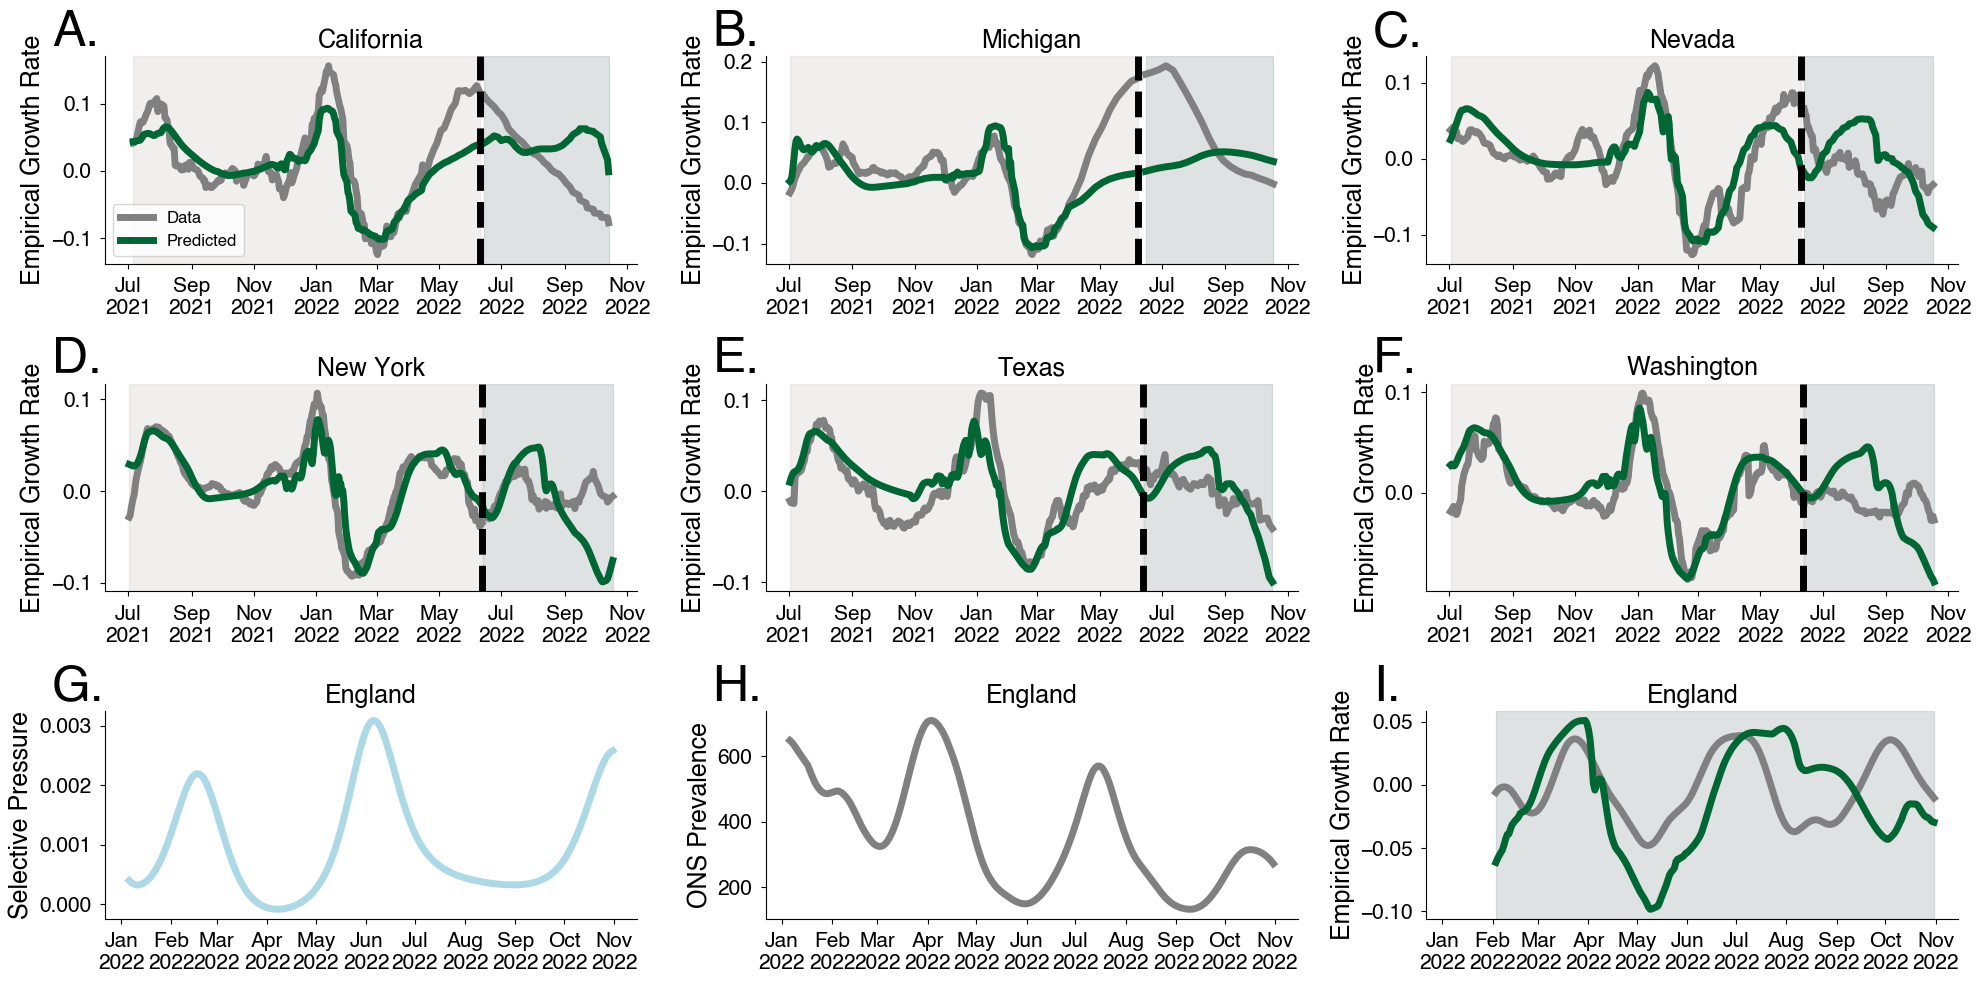

In [36]:
fig = plt.figure(figsize=(20, 10))
spec = fig.add_gridspec(ncols=3, nrows=len(locations_subset) // 3 + 1)

TRAIN_PERIOD_COLOR, TEST_PERIOD_COLOR = "#d1c7c9", "#949fa5"
PREDICTION_COLOR = "#006633"
DATA_COLOR = "grey"

axes = []

data = {loc: df for loc, df in selective_pressure_df.groupby("location")}

for l, loc in enumerate(locations_subset):
    ax = fig.add_subplot(spec[l], sharex=None if l==0 else ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X_train.index]
    loc_idx_test = loc_idx[X_test.index]

    # Plot data point
    ax.plot(dates_vec[X_train.index][loc_idx_train], y_train[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    pred_train = model_bd(X_train[loc_idx_train].values, deterministic=True)
    pred_test = model_bd(X_test[loc_idx_test].values, deterministic=True)
    
    ax.plot(dates_vec[X_train.index][loc_idx_train], pred_train, color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], pred_test, color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X_train.index][loc_idx_train].min(), dates_vec[X_train.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    if l == 0:
        ax.legend()
    axes.append(ax)
    
# Add in target_locations
last_l = l
for l, loc in enumerate(target_locations):
    # Add selective pressure
    _l = 0
    ax = fig.add_subplot(spec[-1, 0], sharex=None if _l==0 else ax)
    ax.plot(data[loc]["date"], data[loc]["selective_pressure"], color="lightblue")
    ax.set_ylabel("Selective Pressure")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
    
    # Add prevalence
    ax = fig.add_subplot(spec[-1, 1], sharex = ax)    
    ax.plot(data[loc]["date"], data[loc]["smooth_cases"], color="grey")
    ax.set_title(loc)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("ONS Prevalence")
    axes.append(ax)
   
    # Add predictions
    ax = fig.add_subplot(spec[-1, -1], sharex=ax)
    loc_idx = locations_vec.values == loc
    loc_idx_train = loc_idx[X_train.index]
    loc_idx_test = loc_idx[X_test.index]
    
    # Plot data points
    ax.plot(dates_vec[X_train.index][loc_idx_train], y_train[loc_idx_train], color=DATA_COLOR, label="Data")
    ax.plot(dates_vec[X_test.index][loc_idx_test], y_test[loc_idx_test], color=DATA_COLOR)
    
    # Make predictions
    pred_train = model_bd(X_train[loc_idx_train].values, deterministic=True)
    pred_test = model_bd(X_test[loc_idx_test].values, deterministic=True)

    ax.plot(dates_vec[X_train.index][loc_idx_train], pred_train, color=PREDICTION_COLOR, label="Predicted")
    ax.plot(dates_vec[X_test.index][loc_idx_test], pred_test, color=PREDICTION_COLOR)
    
    # Highlight test and training sets
    min_train_time, max_train_time = dates_vec[X_train.index][loc_idx_train].min(), dates_vec[X_train.index][loc_idx_train].max()
    if not pd.isnull(max_train_time):
        ax.axvline(max_train_time, color="k", linestyle="--")
        ax.axvspan(min_train_time, max_train_time, color=TRAIN_PERIOD_COLOR, alpha=0.3)
    
    min_test_time, max_test_time = dates_vec[X_test.index][loc_idx_test].min(), dates_vec[X_test.index][loc_idx_test].max()
    if not pd.isnull(max_test_time):
        ax.axvspan(min_test_time, max_test_time, color=TEST_PERIOD_COLOR, alpha=0.3)
    
    ax.set_ylabel("Empirical Growth Rate")
    ax.set_title(loc)
    
    # Format dates
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)

ax_labels = string.ascii_uppercase 
for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.1, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
fig.tight_layout()